# Predicting Survival on the Titanic

**_Note! Work in Progress - This notebook is not yet finished_**

An implementation in Python of the exploration of the Titanic dataset that closely follows the excellent *Exploring Survival on the Titanic* notebook by Megan L. Risdal found at https://www.kaggle.com/mrisdal/titanic/exploring-survival-on-the-titanic/notebook. Data preprocessing largely follows what she did though predictive modeling attempts to explore more models than just the random forest she used.

As an aside, this also serves as an interesting look at how some of the tasks performed in her notebook might be done in Python and, in a way, shows both languages' relative strengths and weaknesses.

In [2]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.cross_validation import train_test_split, cross_val_score
from sklearn import metrics

## The Dataset

In [40]:
train = pd.read_csv("train.csv", index_col='PassengerId')
test = pd.read_csv("test.csv", index_col='PassengerId')
train.head(3)
test.head(3)

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,
892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q


In [4]:
# print(train.shape)
# print(test.shape)
print('Number of features: {}'.format(test.shape[1]))
print('Training samples: {}'.format(train.shape[0]))
print('Test samples: {}'.format(test.shape[0]))
print('Total number of samples: {}'.format(train.shape[0]+test.shape[0]))

Number of features: 10
Training samples: 891
Test samples: 418
Total number of samples: 1309


The data contains the following features:

- PassengerId - a number describing a unique passenger
- Survived - the binary dependent variable indicating whether a passenger survived (1) or died (0)
- Pclass - the passenger's class, from first class (1) to third class (3)
- Name
- Sex
- Age
- SibSp - the number of siblings or spouses aboard
- Parch - the number of parents or children aboard
- Ticket - the ticket number
- Fare - the fare that the passenger paid
- Cabin - the cabin number the passenger stayed in
- Embarked - the port where the passenger embarked, whether at Cherbourg (C), Queenstown (Q), or Southampton (S)

It's time to explore the dataset to get a general idea of what it's like.

## Exploratory Data Analysis

We first do some general overviews of the data via summary statistics and histograms before moving on to preprocessing.

In [5]:
# First, combine datasets
total = pd.concat([train, test])

# View summary statistics
total.describe()

C:\Users\Justin\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3834: RuntimeWarning: Invalid value encountered in percentile
  RuntimeWarning)


,Age,Fare,Parch,Pclass,SibSp,Survived
count,1046.000000,1308.000000,1309.000000,1309.000000,1309.000000,891.000000
mean,29.881138,33.295479,0.385027,2.294882,0.498854,0.383838
std,14.413493,51.758668,0.865560,0.837836,1.041658,0.486592
min,0.170000,0.000000,0.000000,1.000000,0.000000,0.000000
25%,NaN,NaN,0.000000,2.000000,0.000000,NaN
50%,NaN,NaN,0.000000,3.000000,0.000000,NaN
75%,NaN,NaN,0.000000,3.000000,1.000000,NaN
max,80.000000,512.329200,9.000000,3.000000,8.000000,1.000000


Most numerical data appear to be fairly complete, with the exception of fare (which only has one missing value) and age (which has 263 missing values). We can deal with the missing values later.

Let's also visualize the data with histograms to see the general distribution of the data.

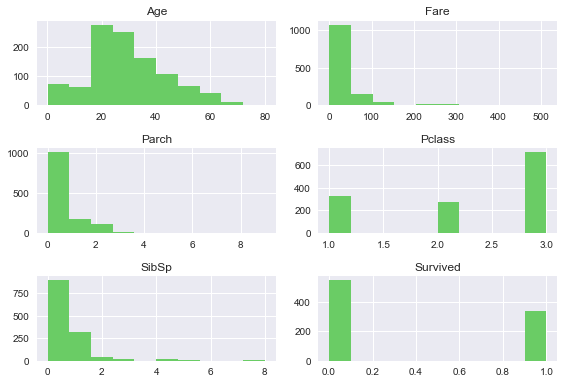

In [6]:
# Generate histograms
sns.set_color_codes('muted')
total.hist(color='g')
plt.tight_layout()
plt.show()

A fairly obvious observation here is that the PassengerId variable is not very useful -- we should drop this column. The rest of the data is quite interesting, with most passengers being somewhat young (around 20 to 30 years of age) and most people traveling without too much family.

Pclass serves as a proxy for the passengers' socioeconomic stata. Interestingly, the middle class appears to be the lowest in size, though not by much compared to upperclass passengers.

Looking at the data, given that we don't have  the ticket number does not appear to be too informative.

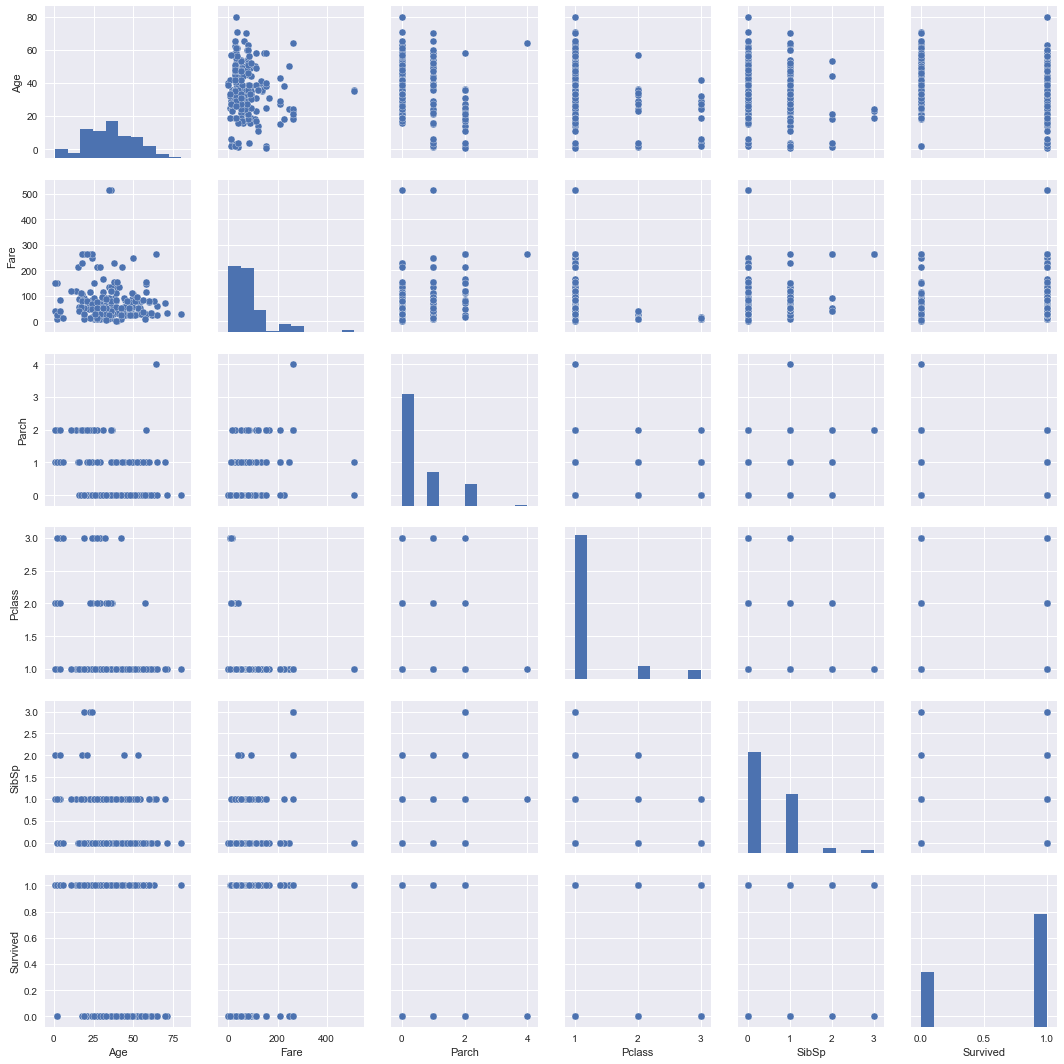

In [9]:
totalwithoutnas = total.dropna()
scattermatrix = sns.pairplot(totalwithoutnas)
plt.show()

## Data Preprocessing

The first thing we should do is drop columns that will not be particularly helpful in our analysis. This includes the Ticket variable identified previously.

In [11]:
total.drop('Ticket', axis=1, inplace=True)

### Feature Engineering

A number of the variables in the data present opportunities to be further generate meaningful features. One particular feature that appears to contain a lot of meaning is the names of the passengers. As in the notebook of Megan, we will be able to extract titles (which are indicative of both gender and marriage status) and families (given by shared surnames, under the assumption that incidences of unrelated people having the same surname are trivial).

#### Surnames and Titles

In [12]:
Surnames = pd.DataFrame(total['Name'].str.split(",").tolist(), columns=['Surname', 'Rest'])
Titles = pd.DataFrame(Surnames['Rest'].str.split(".").tolist(), columns=['Title', 'Rest1', 'Rest2'])

Surnames.drop('Rest',axis=1,inplace=True)
Titles = pd.DataFrame(Titles['Title'])

Surnames['Surname'].str.strip()
Titles['Title'].str.strip()

total['Surname'] = Surnames.set_index(np.arange(1,1310))
total['Title'] = Titles.set_index(np.arange(1,1310))

total.head()

,Age,Cabin,Embarked,Fare,Name,Parch,Pclass,Sex,SibSp,Survived,Surname,Title
PassengerId,,,,,,,,,,,,
1,22.0,NaN,S,7.2500,"Braund, Mr. Owen Harris",0,3,male,1,0.0,Braund,Mr
2,38.0,C85,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,1,female,1,1.0,Cumings,Mrs
3,26.0,NaN,S,7.9250,"Heikkinen, Miss. Laina",0,3,female,0,1.0,Heikkinen,Miss
4,35.0,C123,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,1,female,1,1.0,Futrelle,Mrs
5,35.0,NaN,S,8.0500,"Allen, Mr. William Henry",0,3,male,0,0.0,Allen,Mr


Let's tabulate our titles against sex to see the frequency of the various titles.

In [13]:
pd.crosstab(total['Sex'], total['Title'])

Title,Capt,Col,Don,Dona,Dr,Jonkheer,Lady,Major,Master,Miss,Mlle,Mme,Mr,Mrs,Ms,Rev,Sir,the Countess
Sex,,,,,,,,,,,,,,,,,,
female,0,0,0,1,1,0,1,0,0,260,2,1,0,197,2,0,0,1
male,1,4,1,0,7,1,0,2,61,0,0,0,757,0,0,8,1,0


We see that with the exception of Master, Mr, Miss, and Mrs, the other titles are relatively rare. We can group rare titles together to simplify our analysis. Also note that Mlle and Ms are synonymous with Miss, and Mme is synonymous with Mrs.

In [14]:
raretitles = ['Dona', 'Lady', 'the Countess','Capt', 'Col', 'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer']

total.ix[total['Title'].str.contains('Mlle|Ms|Miss'), 'Title'] = 'Miss'
total.ix[total['Title'].str.contains('Mme|Mrs'), 'Title'] = 'Mrs'
total.ix[total['Title'].str.contains('|'.join(raretitles)), 'Title'] = 'Rare Title'

pd.crosstab(total['Sex'], total['Title'])

Title,Master,Mr,Miss,Mrs,Rare Title
Sex,,,,,
female,0,0,264,198,4
male,61,757,0,0,25


In [17]:
total['Surname'].nunique()

875

We have 875 unique surnames.

#### Family Sizes

Family size may have an impact on survival. To this end, we create a family size attribute and plot the relationship.

In [25]:
total['FamilySize'] = total['SibSp'] + total['Parch'] + 1

total['Family'] = total['Surname'] + "_" + total['FamilySize'].apply(str)

total.head(1)

,Age,Cabin,Embarked,Fare,Name,Parch,Pclass,Sex,SibSp,Survived,Surname,Title,FamilySize,Family
PassengerId,,,,,,,,,,,,,,
1,22.0,NaN,S,7.25,"Braund, Mr. Owen Harris",0,3,male,1,0.0,Braund,Mr,2,Braund_2


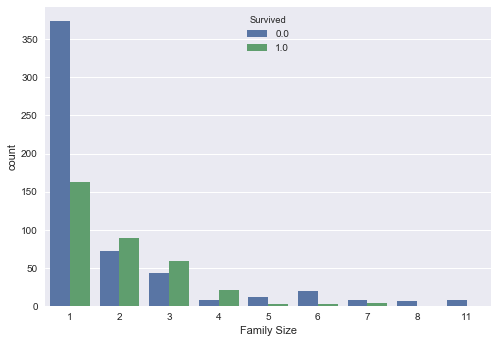

In [45]:
# Plot family size
famsizebarplot = sns.countplot(total['FamilySize'].loc[1:len(train.index)], hue=total['Survived'])
famsizebarplot.set_xlabel('Family Size')
plt.show()

The chart above clearly shows an interesting phenomenon -- single people and families of over 4 people have a significantly lower chance of survival than those in small (2 to 4 person) families.

In [49]:
# Categorize family size
total['FamSizeCat'] = 'small'
total.loc[(total['FamilySize'] == 1), 'FamSizeCat'] = 'singleton'
total.loc[(total['FamilySize'] > 4), 'FamSizeCat'] = 'large'

# Create mosaic plot
# To be done in the future using statsmodel

### Dealing with Missing Values

We first check columns with missing values.

In [52]:
total.isnull().sum()

Age            263
Cabin         1014
Embarked         2
Fare             1
Name             0
Parch            0
Pclass           0
Sex              0
SibSp            0
Survived       418
Surname          0
Title            0
FamilySize       0
Family           0
FamSizeCat       0
dtype: int64

It appears that age, cabin, embarked, and fare have missing values. Let's first work on "Embarked" and "Fare" given that there are few enough NaN's for us to be able to manually work out what values they should have. For Cabin, given that there are 1309 samples and more than 75% of them are missing, we can probably just drop this column. It might have been useful given that location on the ship might influence their chance of survival, but data is too sparse on this particular attribute.

In [59]:
total[(total['Embarked'].isnull()) | (total['Fare'].isnull())]

,Age,Cabin,Embarked,Fare,Name,Parch,Pclass,Sex,SibSp,Survived,Surname,Title,FamilySize,Family,FamSizeCat
PassengerId,,,,,,,,,,,,,,,
62,38.0,B28,NaN,80.0,"Icard, Miss. Amelie",0,1,female,0,1.0,Icard,Miss,1,Icard_1,singleton
830,62.0,B28,NaN,80.0,"Stone, Mrs. George Nelson (Martha Evelyn)",0,1,female,0,1.0,Stone,Mrs,1,Stone_1,singleton
1044,60.5,NaN,S,NaN,"Storey, Mr. Thomas",0,3,male,0,NaN,Storey,Mr,1,Storey_1,singleton


Miss Icard and Mrs. Stone,  both shared the same cabin, both survived, both paid the same fare, and are both of the same class, interestingly enough. Mr. Storey is of the third class and embarked from Southampton.

Visualizing the fares by embarkation location may shed some light on where the two first class ladies embarked.

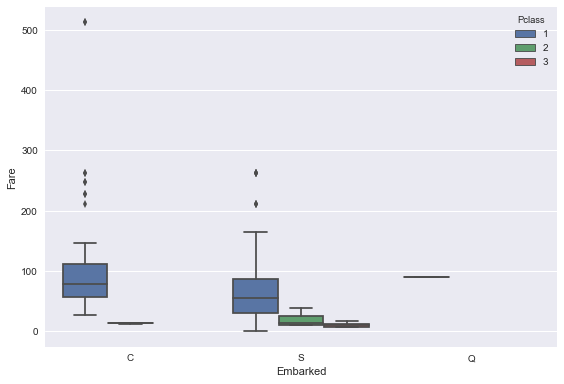

In [64]:
sns.boxplot(x='Embarked',y='Fare',data=train.dropna(),hue='Pclass')
plt.tight_layout()
plt.show()

In [87]:
trainwithoutnas = train.dropna()
print("Mean fares for passengers traveling in first class:")
print(trainwithoutnas[trainwithoutnas['Pclass']==1].groupby('Embarked')['Fare'].mean())
print("\nMedian fares for passengers traveling in first class:")
print(trainwithoutnas[trainwithoutnas['Pclass']==1].groupby('Embarked')['Fare'].median())

Mean fares for passengers traveling in first class:
Embarked
C    106.199937
Q     90.000000
S     76.788754
Name: Fare, dtype: float64

Median fares for passengers traveling in first class:
Embarked
C    78.2667
Q    90.0000
S    55.9000
Name: Fare, dtype: float64


The closest value to the $80 fare paid by both ladies for first class is very close to the mean fare paid by first class passengers embarking from Southampton, but also aligns very nicely with the median fare paid by those embarking from Cherbourg. Perhaps a swarm plot will better show how passengers are distributed.

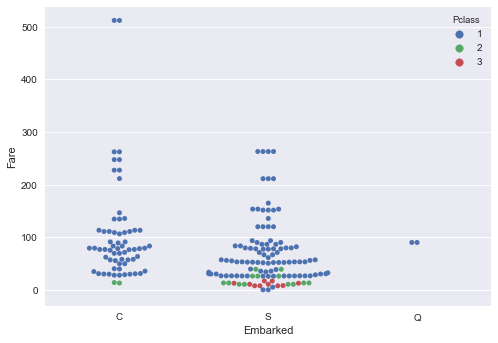

In [92]:
sns.swarmplot(x='Embarked',y='Fare',data=train.dropna(),hue='Pclass')
plt.show()

This is a tough call. Looking at the spread of the points, however, it seems that those that embarked from Southampton generally paid lower fares. It appears that the mean fare paid by those from Cherbourg is pulled up by the extreme outliers that paid more than \$500 for their tickets, with a majority of first class passengers indeed paying around $80. As such, we classify the two ladies as having embarked from Cherbourg (C).

In [98]:
total.loc[(62,830), 'Embarked'] = "C"
total.loc[(62,830), 'Embarked']

PassengerId
62     C
830    C
Name: Embarked, dtype: object

The swarm plot also shows that the passengers embarking from Southampton in third class have paid around the same fare. It would be reasonable to use the mean value of third class passengers from Southampton as his fare value.

In [112]:
total.loc[1044,'Fare'] = total[(total['Embarked']=="S") & (total['Pclass']==3)]['Fare'].mean()
total.loc[1044, ['Name','Fare']]

Name    Storey, Mr. Thomas
Fare               14.4354
Name: 1044, dtype: object

We could do mice imputation similar to Megan's notebook via the fancyimpute package.

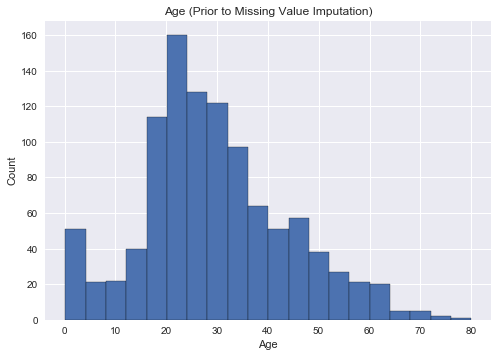

In [191]:
AgeHistogram = total['Age'].hist(bins=20, edgecolor="black")
AgeHistogram.set_xlabel("Age")
AgeHistogram.set_ylabel("Count")
AgeHistogram.set_title("Age (Prior to Missing Value Imputation)")
plt.show()

In [132]:
import fancyimpute
total.isnull().sum()

Age            263
Cabin         1014
Embarked         0
Fare             0
Name             0
Parch            0
Pclass           0
Sex              0
SibSp            0
Survived       418
Surname          0
Title            0
FamilySize       0
Family           0
FamSizeCat       0
dtype: int64

In [202]:
totalforMICE = total.drop(['Survived','Cabin','FamSizeCat','Family','Name','Surname'], axis=1)
# totalforMICE.fillna(np.nan)
totalforMICE['Sex'] = pd.get_dummies(totalforMICE['Sex'])['male']
dummycodedTitles = pd.get_dummies(totalforMICE['Title']).drop('Rare Title', axis=1)
totalforMICE = pd.merge(totalforMICE, dummycodedTitles, left_index=True, right_index=True, how='outer')
totalforMICE = totalforMICE.drop(['Title'],axis=1)
dummycodedEmbarked = pd.get_dummies(totalforMICE['Embarked'])[['C','Q']]
totalforMICE = totalforMICE.join(dummycodedEmbarked).drop(['Embarked'],axis=1)
dummycodedPclass = pd.get_dummies(totalforMICE['Pclass'], columns=[list("123")]).drop(3,axis=1)
totalforMICE = totalforMICE.join(dummycodedPclass).drop('Pclass',axis=1)
MICEdtotal = fancyimpute.MICE().complete(totalforMICE.values.astype(float))

[MICE] Completing matrix with shape (1309, 14)
[MICE] Starting imputation round 1/110, elapsed time 0.000
[MICE] Starting imputation round 2/110, elapsed time 0.001
[MICE] Starting imputation round 3/110, elapsed time 0.001
[MICE] Starting imputation round 4/110, elapsed time 0.002
[MICE] Starting imputation round 5/110, elapsed time 0.002
[MICE] Starting imputation round 6/110, elapsed time 0.003
[MICE] Starting imputation round 7/110, elapsed time 0.003
[MICE] Starting imputation round 8/110, elapsed time 0.003
[MICE] Starting imputation round 9/110, elapsed time 0.004
[MICE] Starting imputation round 10/110, elapsed time 0.004
[MICE] Starting imputation round 11/110, elapsed time 0.005
[MICE] Starting imputation round 12/110, elapsed time 0.005
[MICE] Starting imputation round 13/110, elapsed time 0.006
[MICE] Starting imputation round 14/110, elapsed time 0.006
[MICE] Starting imputation round 15/110, elapsed time 0.007
[MICE] Starting imputation round 16/110, elapsed time 0.007
[M

In [203]:
MICEdtotal = pd.DataFrame(MICEdtotal, columns=totalforMICE.columns)
MICEdtotal.isnull().sum()

Age           0
Fare          0
Parch         0
Sex           0
SibSp         0
FamilySize    0
 Master       0
 Mr           0
Miss          0
Mrs           0
C             0
Q             0
1             0
2             0
dtype: int64

We see that the MICE'd data has no more missing Age values. Plotting these values in the histogram:

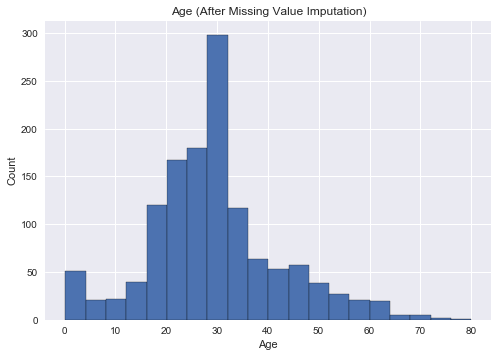

In [204]:
MICEAgeHistogram = MICEdtotal['Age'].hist(bins=20, edgecolor="black")
MICEAgeHistogram.set_xlabel("Age")
MICEAgeHistogram.set_ylabel("Count")
MICEAgeHistogram.set_title("Age (After Missing Value Imputation)")
plt.show()

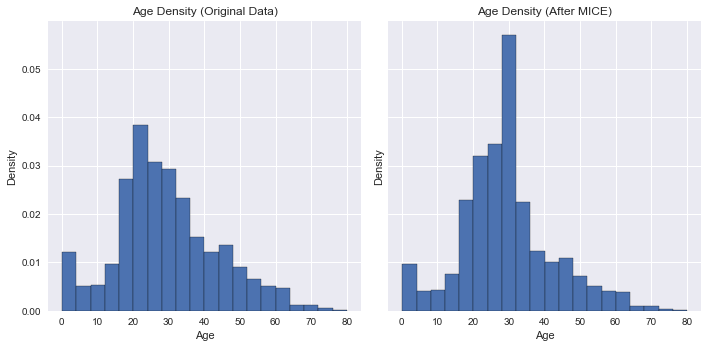

In [236]:
AgeHists, AgeHistAxes = plt.subplots(nrows=1,ncols=2, figsize=(10,5), sharey=True)

AgeHistAxes[0].hist(total['Age'].dropna(), bins=20, edgecolor='black', normed=True)
AgeHistAxes[0].set_xlabel("Age")
AgeHistAxes[0].set_ylabel("Density")
AgeHistAxes[0].set_title("Age Density (Original Data)")

AgeHistAxes[1].hist(MICEdtotal['Age'], bins=20, edgecolor='black', normed=True)
AgeHistAxes[1].set_xlabel("Age")
AgeHistAxes[1].set_ylabel("Density")
AgeHistAxes[1].set_title("Age Density (After MICE)")

AgeHists.tight_layout()
AgeHists

Most age values were added around the 20 to 30 year-old age range, which makes sense given the distribution of the ages in the data that we had. Note that the fancyimpute version of MICE uses Bayesian Ridge Regression. The density is not perfectly preserved but is useful enough to proceed with the analysis.

We use the new Age column with the imputed values for our analysis.

In [237]:
newtotal = total
newtotal['Age'] = MICEdtotal['Age']

We can create some additional categorical columns based on our complete age feature -- whether the person is a child (18 or under) and whether a person is a mother (female, over 18, with children, and does not have the title "Miss").

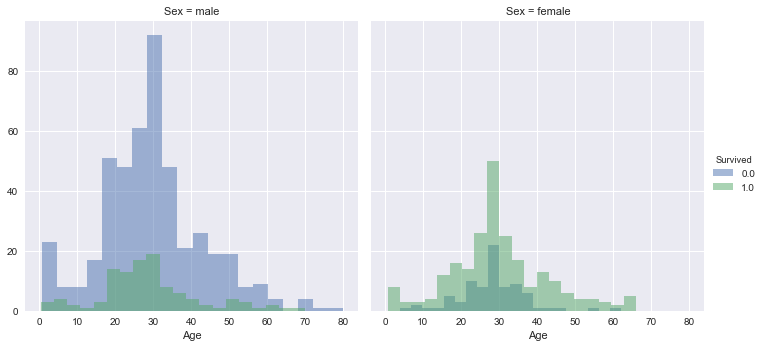

In [327]:
AgeandSexHist = sns.FacetGrid(newtotal.iloc[0:891,:], col = 'Sex', hue='Survived', size=5)
# AgeandSexHist.map(sns.distplot, 'Age', kde=False, hist_kws={'edgecolor':'black','stacked':True})
AgeandSexHist.map(plt.hist, 'Age', alpha=0.5, bins=20)
AgeandSexHist.add_legend()
# plt.close('all')
plt.show(AgeandSexHist)

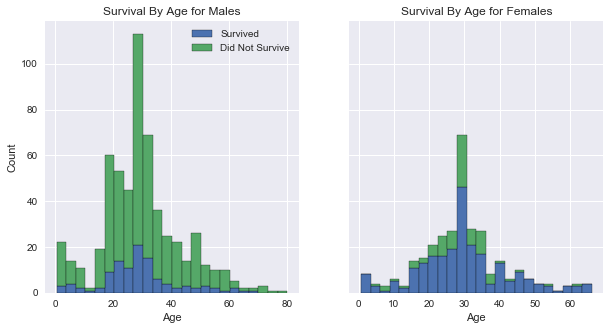

In [342]:
AgeandSexHist, AgeandSexHistAxes = plt.subplots(nrows=1,ncols=2, figsize=(10,5), sharey=True)
AgeandSexHistAxes[0].hist([newtotal.loc[0:891, 'Age'].loc[(newtotal['Sex']=='male') & (newtotal['Survived']==1)],
          newtotal.loc[0:891, 'Age'].loc[(newtotal['Sex']=='male') & (newtotal['Survived']==0)]],stacked=True, edgecolor='black', label=['Survived','Did Not Survive'], bins=24)
AgeandSexHistAxes[1].hist([newtotal.loc[0:891, 'Age'].loc[(newtotal['Sex']=='female') & (newtotal['Survived']==1)],
          newtotal.loc[0:891, 'Age'].loc[(newtotal['Sex']=='female') & (newtotal['Survived']==0)]],stacked=True, edgecolor='black', bins=24)
AgeandSexHistAxes[0].set_title('Survival By Age for Males')
AgeandSexHistAxes[1].set_title('Survival By Age for Females')
for i in range(2):
    AgeandSexHistAxes[i].set_xlabel('Age')
AgeandSexHistAxes[0].set_ylabel('Count')
AgeandSexHistAxes[0].legend()
plt.show()

In [343]:
# Create the 'Child' variable
newtotal['Child'] = 1
newtotal.loc[newtotal['Age']>=18, 'Child'] = 0

pd.crosstab(newtotal['Child'],newtotal['Survived'])

Survived,0.0,1.0
Child,,
0,477,299
1,72,43


In [345]:
# Create the 'Mother' variable
newtotal['Mother'] = 0
newtotal.loc[(newtotal['Sex']=='female') & (newtotal['Parch'] > 0) & (newtotal['Age']>18) & (newtotal['Title'] != "Miss"), 'Mother'] = 1

pd.crosstab(newtotal['Mother'], newtotal['Survived'])

Survived,0.0,1.0
Mother,,
0,534,311
1,15,31


Let's take a look at the dataset once again.

In [346]:
newtotal.head()

,Age,Cabin,Embarked,Fare,Name,Parch,Pclass,Sex,SibSp,Survived,Surname,Title,FamilySize,Family,FamSizeCat,Child,Mother
PassengerId,,,,,,,,,,,,,,,,,
1,38.000000,NaN,S,7.2500,"Braund, Mr. Owen Harris",0,3,male,1,0.0,Braund,Mr,2,Braund_2,small,0,0
2,26.000000,C85,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,1,female,1,1.0,Cumings,Mrs,2,Cumings_2,small,0,0
3,35.000000,NaN,S,7.9250,"Heikkinen, Miss. Laina",0,3,female,0,1.0,Heikkinen,Miss,1,Heikkinen_1,singleton,0,0
4,35.000000,C123,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,1,female,1,1.0,Futrelle,Mrs,2,Futrelle_2,small,0,0
5,29.783901,NaN,S,8.0500,"Allen, Mr. William Henry",0,3,male,0,0.0,Allen,Mr,1,Allen_1,singleton,0,0


In [349]:
newtotal.shape

(1309, 17)

We ensure that all important categorical variables are dummy coded.

In [356]:
dummycodedFamSizeCat = pd.get_dummies(newtotal['FamSizeCat']).drop('large',axis=1)
newtotal = newtotal.drop(['Title','Embarked','Pclass', 'Cabin', 'Name', 'Family', 'Surname'], axis=1)
newtotal['Sex'] = pd.get_dummies(newtotal['Sex'])['male']
newtotal = newtotal.join(dummycodedEmbarked)
newtotal = newtotal.join(dummycodedPclass)
newtotal = newtotal.join(dummycodedTitles)
newtotal = newtotal.join(dummycodedFamSizeCat)
newtotal.head()

,Age,Fare,Parch,Sex,SibSp,Survived,FamilySize,FamSizeCat,Child,Mother,C,Q,1,2,Master,Mr,Miss,Mrs,singleton,small
PassengerId,,,,,,,,,,,,,,,,,,,,
1,38.000000,7.2500,0,1.0,1,0.0,2,small,0,0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
2,26.000000,71.2833,0,0.0,1,1.0,2,small,0,0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
3,35.000000,7.9250,0,0.0,0,1.0,1,singleton,0,0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
4,35.000000,53.1000,0,0.0,1,1.0,2,small,0,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
5,29.783901,8.0500,0,1.0,0,0.0,1,singleton,0,0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0


After we split the data back into training and test sets, our data set will be ready to use for modeling.

In [358]:
newtrain = newtotal.loc[:891,:]
newtest = newtotal.loc[892:,:]

## Modeling and Prediction

**_Note! Work in Progress - This notebook is not yet finished_**